In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner
import copy
import pickle
from astropy.io import ascii
from itertools import cycle
import math
from itertools import permutations

import matplotlib.gridspec as gridspec

%matplotlib inline

# Plotting code

In [2]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=3
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=12
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5


def makeCmap(hexColour,zeroColour='#FFFFFF'):
    r0,g0,b0=mpl.colors.hex2color(zeroColour)
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r0, r0),
                   (1.0, r, r)),
         'green': ((0.0, g0, g0),
                   (1.0, g, g)),
         'blue':  ((0.0, b0, b0),
                   (1.0, b, b))
        }
    cmap = mpl.colors.LinearSegmentedColormap(hexColour,cdict)
    return cmap


def makeGradient(hexColour):
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r, r),
                   (1.0, r, r)),
         'green': ((0.0, g, g),
                   (1.0, g, g)),
         'blue':  ((0.0, b, b),
                   (1.0, b, b)),
         'alpha':  ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0))
        }
    cmap = mpl.colors.LinearSegmentedColormap(hexColour,cdict)
    return cmap


def makePlotColours(mappableList,coloursList):
    """
    mappableArray = a list of discrete values, each corresponding to a unique color (zero-indexed)
    coloursList = list of desired colors. Ideally should be at least as many colours as there are unique
                  entries in mappableArray.
    """

    nColours = np.max(mappableList)+1
    uniqueMappableList = np.arange(nColours)
    
    zidx = np.array((mappableList))

    cidx = 0
    colourMaps = []
    cycledColours = []
    for c in cycle(coloursList):
        colourMaps.append(makeGradient(c))
        cycledColours.append(c)
        cidx+=1
        if cidx >= nColours: 
            break
    
    blankCmap=makeGradient('#FFFFFF')
    colours = blankCmap(0.999*np.ones_like(zidx))

    for j in range(0,nColours):
        colours[zidx==j] = colourMaps[j](0.999*np.ones_like(np.arange(0,len(zidx))[zidx==j]))

    return colourMaps,colours,cycledColours,list(uniqueMappableList)

In [3]:
def makePlot(ax, xdata, ydata, colours, xlabel, ylabel, sizes=100,
             legendTitle=None,legendEntries=None, legendColours=None,
             xlim=[], ylim=[],xscale="linear",yscale="linear",alpha=1):
    ax.scatter(xdata,ydata,c=colours,s=sizes,alpha=alpha)
    #ax.hexbin(xdata,ydata,cmap='Blues')
    nonans = (np.isfinite(xdata) & np.isfinite(ydata))
    xdata=xdata[nonans]
    ydata=ydata[nonans]
    colours=colours[nonans]
    
    xmin = np.min(xdata[xdata > 0.])#.value
    xmax = np.max(xdata)#.value
    
    ymin = np.min(ydata[ydata > 0.])#.value
    ymax = np.max(ydata)#.value

    if not xlim:
        if xscale=="log":
            ax.set_xlim(0.1*xmin,10.*xmax)
        else:
            ax.set_xlim(0.95*xmin,1.05*xmax)
    else:
        ax.set_xlim(xlim)
        
    if not ylim:
        if yscale=="log":
            ax.set_ylim(0.1*ymin,10.*ymax)
        else:
            ax.set_ylim(0.95*ymin,1.05*ymax)
    else:
        ax.set_ylim(ylim)
    
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    
    ax.set_xlabel(xlabel,fontsize=24)
    ax.set_ylabel(ylabel,fontsize=24)
    ax.tick_params(labelsize=18)
    
    if legendEntries is not None:
        if xscale=="log":
            minx = 1.e-7*xmin
        else:
            minx = -1000+(-1000*xmin)
                
        if yscale=="log":
            miny = 1.e-7*ymin
        else:
            miny = -1000+(-1000*ymin)
            
        for i in range(0,len(legendEntries)):
            ax.scatter([minx,minx],[miny,miny],s=200,c=legendColours[i],edgecolors=legendColours[i],label='{0}'.format(legendEntries[i]))
        leg=ax.legend(loc=0,ncol=1,frameon=False,fontsize=15,title=legendTitle)
        leg.get_title().set_fontsize('22')
    return 

# Planet data in usable format
## each planet object includes some combination of: [Teff, logg, [Fe/H], Rp/R*, P]

In [4]:
experimentClass = "crossValidation"
experimentName = "Rp_uniformP_sigma=0.005"
seed = 257

n_planet_features = 2
n_stellar_features = 3
n_features = n_planet_features + n_stellar_features

-1.0680931919209014
1.5409327511915483


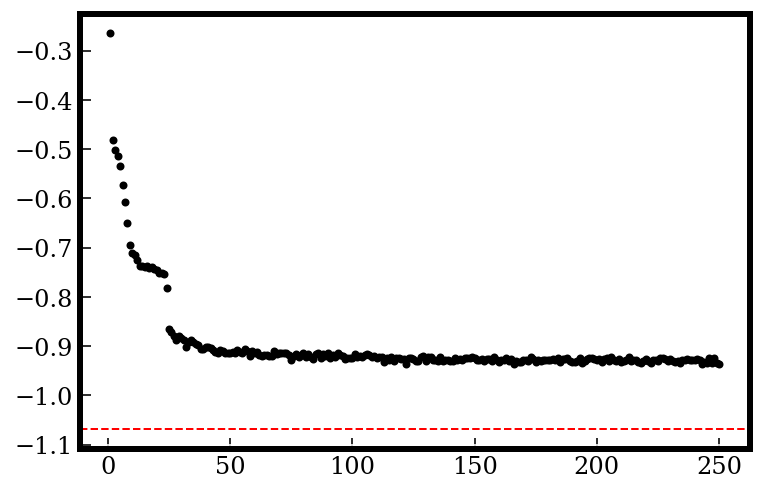

In [5]:
results = np.load("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_classprobs_softmax_{2}.npy".format(experimentClass,experimentName,seed))
results_fromContext = np.load("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_classprobs_fromcontext_logsoftmax_{2}.npy".format(experimentClass,experimentName,seed))

idxs = np.load("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_idxs_{2}.npy".format(experimentClass,experimentName,seed))
losses = np.load("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_losses_{2}.npy".format(experimentClass,experimentName,seed))

optimalLoss = float(np.load("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_optimalLoss_{2}.npy".format(experimentClass,experimentName,seed)))
print(optimalLoss)
bits = -1*optimalLoss*math.log(math.e,2)
print(bits)
plt.plot(losses[:,0],losses[:,1],'k.')
plt.axhline(y=optimalLoss,color='r',ls="--",lw=1)
plt.show()

In [7]:
print(np.shape(results))
print(results[0:10])
print(np.shape(results_fromContext))
print(results_fromContext[0:10])

(18961, 3)
[[4.61749583e-10 4.61749583e-10 1.00000000e+00]
 [1.94117006e-17 1.00000000e+00 1.94117006e-17]
 [2.09272898e-21 1.00000000e+00 2.09272898e-21]
 [3.04679307e-12 3.04679307e-12 1.00000000e+00]
 [2.51058099e-13 2.51058099e-13 1.00000000e+00]
 [1.22967692e-10 1.22967692e-10 1.00000000e+00]
 [6.67413277e-11 6.67413277e-11 1.00000000e+00]
 [3.55841809e-18 1.00000000e+00 3.55841809e-18]
 [7.39883799e-09 7.39883799e-09 1.00000000e+00]
 [4.14820088e-14 1.00000000e+00 4.14820088e-14]]
(18961, 3)
[[-6.54252529e+00 -6.54252529e+00 -2.88582291e-03]
 [-7.34039164e+00 -4.19296697e-03 -5.64491701e+00]
 [-7.56271362e+00 -1.62588432e-03 -6.80782223e+00]
 [-7.01079702e+00 -7.01079702e+00 -1.80581980e-03]
 [-5.17127371e+00 -5.17127371e+00 -1.14196464e-02]
 [-3.37818646e+00 -2.03361467e-01 -1.89773726e+00]
 [-5.56464005e+00 -5.56464005e+00 -7.69141177e-03]
 [-1.04367132e+01 -8.72573946e-05 -9.75649357e+00]
 [-5.49798191e-01 -3.24045420e+00 -9.57665861e-01]
 [-5.01755619e+00 -1.33299120e-02 -5.0

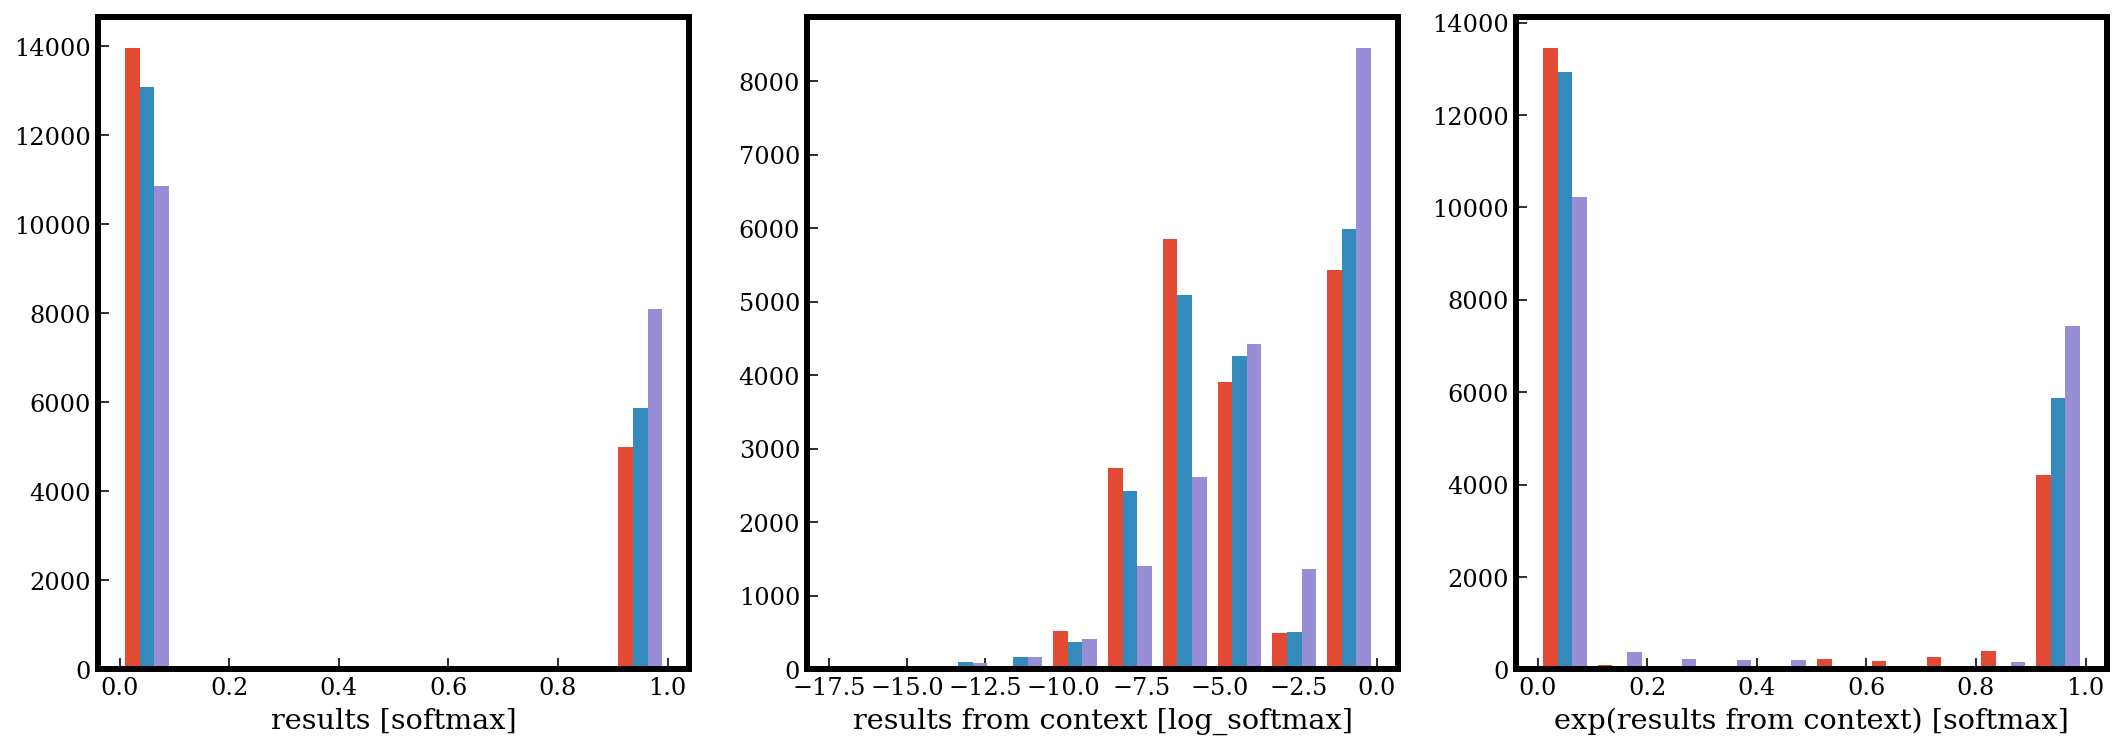

In [11]:
fig, axes = plt.subplots(1,3,figsize=(18,6))
axes[0].hist(results)
axes[0].set_xlabel("results [softmax]")
axes[1].hist(results_fromContext)
axes[1].set_xlabel("results from context [log_softmax]")
axes[2].hist(np.exp(results_fromContext))
axes[2].set_xlabel("exp(results from context) [softmax]")
plt.show()

(18961, 5)
[2 1 1 ... 0 0 2]
(18961,)


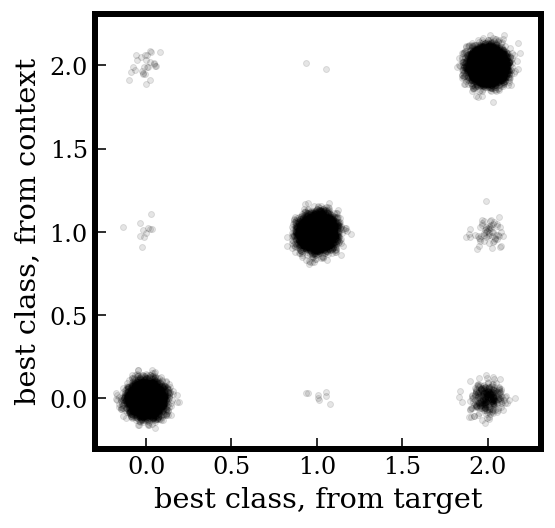

(18961,)
[1 0 0 ... 2 2 1]


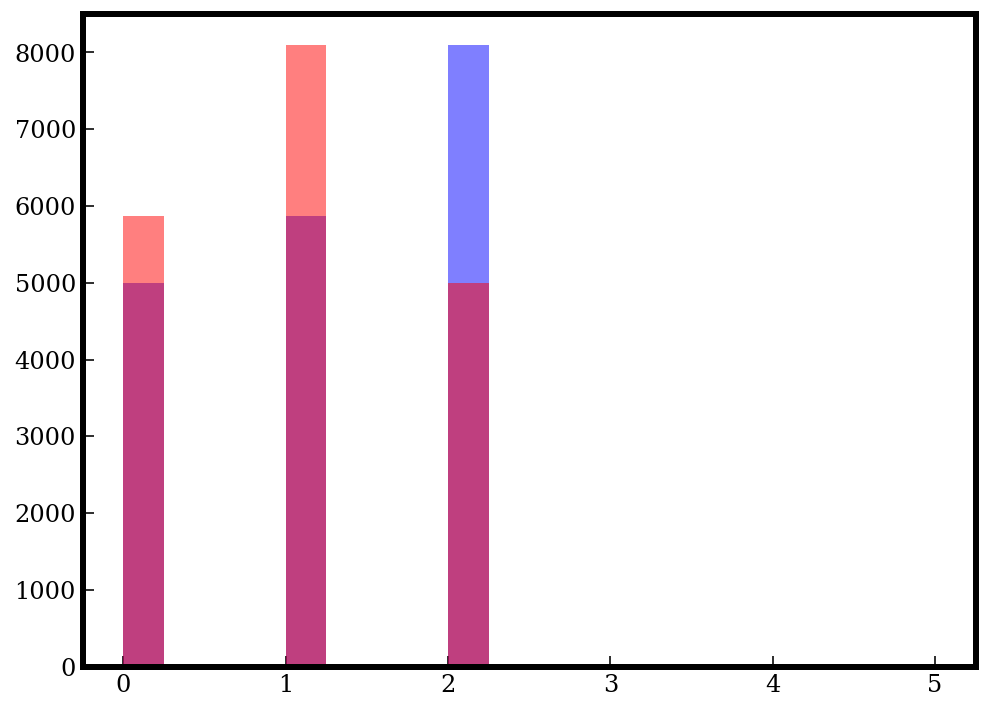

In [12]:
with open("simulatedPlanets/{0}/fake_grammaticalSystems_{1}.txt".format(experimentClass,experimentName), "rb") as picklefile:
    systems = pickle.load(picklefile)

data = np.zeros((1,n_features))

for i in range(len(systems)):
    sys = systems[i]
    for j in range(len(sys)):
        data = np.vstack((data,np.array(sys[j])))
        
data = data[1:][idxs]
print(np.shape(data))

bestClass = np.argmax(results,axis=1)
bestClass_fromContext = np.argmax(results_fromContext,axis=1)
print(bestClass)
print(np.shape(bestClass))

fig = plt.figure(figsize=(4,4))
plt.scatter(bestClass+np.random.normal(loc=0.0,scale=0.05,size=len(bestClass)),
            bestClass_fromContext+np.random.normal(loc=0.0,scale=0.05,size=len(bestClass_fromContext)),
            color='k',marker='.',alpha=0.1)
plt.xlabel("best class, from target")
plt.ylabel("best class, from context")
plt.show()


trueClass = np.load("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_truths.npy".format(experimentClass,experimentName))
trueClass = trueClass[idxs].astype(int)
print(np.shape(trueClass))
print(trueClass)

#note ---the bars don't line up in this histogram because the class labels are out of order!
fig = plt.figure(figsize=(8,6))
plt.hist(bestClass,bins=20,range=(0,5),color='b',alpha=0.5)
plt.hist(trueClass,bins=20,range=(0,5),color='r',alpha=0.5)
plt.show()

In [13]:
def permuteLabels(trueClass, bestClass, bestClass_fromContext):
    
    #get all possible permutations of 0,1,...,nLabels-1
    nLabels = np.max(bestClass) + 1
    labels = np.arange(nLabels)
    perms = set()
    for perm in permutations(labels):
        perms.add(perm)
    
    perms = list(perms)
    
    bestClass_temp = np.zeros_like(bestClass)
    bestClass_fromContext_temp = np.zeros_like(bestClass_fromContext)
    bestPerm = tuple((0,1,2))
    nTarget_wrong = len(bestClass_temp)
    for p in perms:
        for k in range(0,len(p)):
            bestClass_temp[bestClass == k] = p[k]
            
        #evaluate number of "wrong" labels
        nTarget_wrong_temp = len(np.arange(len(bestClass_temp))[bestClass_temp != trueClass])
        if nTarget_wrong_temp < nTarget_wrong:
            bestPerm = p
            nTarget_wrong = nTarget_wrong_temp
            
    for i in range(nLabels):
        bestClass_temp[bestClass == i] = bestPerm[i]
        bestClass_fromContext_temp[bestClass_fromContext == i] = bestPerm[i]
    
    return bestClass_temp, bestClass_fromContext_temp

In [14]:
bestClass_rearr, bestClass_fromContext_rearr = permuteLabels(trueClass, bestClass, bestClass_fromContext)

In [16]:
# figure out nWrong, nDisagree, and then see if calculating the loss function on 
#(perfectly confident results with nWrong, wrong)
# matches what we get

print(len(bestClass))

nTarget_wrong = len(np.arange(len(bestClass))[bestClass != trueClass])
nContext_wrong = len(np.arange(len(bestClass))[bestClass_fromContext != trueClass])
nDisagree = len(np.arange(len(bestClass))[bestClass != bestClass_fromContext])

#print(nTarget_wrong)
#print(nContext_wrong)
print(nDisagree)
print(np.unique(bestClass))
print(np.unique(bestClass_fromContext))
#nTarget_wrong = len(np.arange(len(bestClass))[bestClass_rearr != trueClass])
#nContext_wrong = len(np.arange(len(bestClass))[bestClass_fromContext_rearr != trueClass])
#nDisagree = len(np.arange(len(bestClass))[bestClass_rearr != bestClass_fromContext_rearr])

#print(nTarget_wrong)
#print(nContext_wrong)
#print(nDisagree)

18961
431
[0 1 2]
[0 1 2]


In [17]:
#labels = [r'$R_p\ [R_\odot]$']
#scaledLimits = [(-3.5,2.5)]

#labels = [r'$R_p\ [R_\odot]$',r'P [days]']
#scaledLimits = [(-1.5,4.),(-1.,4.)]
#scaledLimits = [(-1.5,4),(-2.,2.)]

#labels = [r'$R_p\ [R_\odot]$',r'$T_{eff}$ [K]']
#scaledLimits = [(-3.5,2.5),(-4,5.5)]

labels = [r'$R_p\ [R_\odot]$',r'P [days]',r'$T_{eff}$ [K]',r'$\log{g}\ [\mathrm{cm}/\mathrm{s}^2]$',r'[Fe/H]',]
#limits = [(3000,8000),(3.0,5.5),(-1.25,0.6),(0.0,0.3),(0,600)]
scaledLimits = [(-2,2.5),(-2.,2.),(-4.,5.5),(-5,3),(-6,3.5)]


In [18]:
"""
classColoursList = ['#36747D','#F6AA1C','#7A1809','#003049','#BF3E0B','#2E8B57','#EE4266','#540D6E','#064F40','#F54D27']
#cl = ['#7A1809','#36747D','#F6AA1C']

# TRUTHS and RESULTS
#arrays_ = [trueClass, bestClass]
#titles_ = ["True","Best"]
#plotTitles_ = ["truths","results"]

arrays_ = [trueClass, bestClass_fromContext]
titles_ = ["True","Best from context"]
plotTitles_ = ["truths","results_fromcontext"]

for h in range(0,2):
#for h in range(1,2):
    class_colourMaps,class_colours,class_legendColours,class_legendEntries = makePlotColours(arrays_[h],classColoursList)
    
    fig = plt.figure(figsize=(7*n_features,7*n_features))
    gs = gridspec.GridSpec(n_features, n_features)

    for i in range(n_features):
        for j in range(n_features):
            if i>j:
                ax = plt.subplot(gs[i,j])
                makePlot(ax,
                        xdata=data[:,j],#+arrays_[h]/3.,
                        ydata=data[:,i],
                        colours=class_colours,
                        xlim=scaledLimits[j],
                        ylim=scaledLimits[i],
                        legendTitle="{0}\nclass\nindex".format(titles_[h]),
                        legendEntries=np.array(class_legendEntries).astype(int),
                        legendColours=class_legendColours,
                        #xscale="log",
                        #yscale="log",
                        xlabel=labels[j],
                        ylabel=labels[i],
                        alpha=0.25)

            if i==j:
                ax = plt.subplot(gs[i,j])
                toHist = []
                nmax = 0
                for k in np.unique(arrays_[h]).astype(int):
                    #toHist.append(data[:,i][arrays_[h]==k])
                    try:
                        n,bins,patches=ax.hist(data[:,i][arrays_[h]==k],bins=100,color=class_legendColours[k],range=scaledLimits[i],alpha=0.65)
                        if np.max(n)>nmax:
                            nmax=np.max(n)
                    except IndexError:
                        n,bins,patches=ax.hist(data[:,i][arrays_[h]==(k)],bins=100,color=class_legendColours[(k-1)],range=scaledLimits[i],alpha=0.65)
                        if np.max(n)>nmax:
                            nmax=np.max(n)
                    
                #n,bins,patches = ax.hist(toHist,density=True,stacked=True,bins=100,color=class_legendColours,range=scaledLimits[i],alpha=1)
                #nmax = np.max(n)
                ax.set_xlabel(labels[i],fontsize=24)
                ax.tick_params(labelsize=18)
                ax.set_xlim(scaledLimits[i])
                ax.set_ylim(0,nmax*1.1)


    plt.subplots_adjust(wspace=0.2,hspace=0.2)
    #plt.show()
    plt.savefig("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_{2}_{3}.png".format(experimentClass,experimentName,plotTitles_[h],seed),fmt="png")
"""

'\nclassColoursList = [\'#36747D\',\'#F6AA1C\',\'#7A1809\',\'#003049\',\'#BF3E0B\',\'#2E8B57\',\'#EE4266\',\'#540D6E\',\'#064F40\',\'#F54D27\']\n#cl = [\'#7A1809\',\'#36747D\',\'#F6AA1C\']\n\n# TRUTHS and RESULTS\n#arrays_ = [trueClass, bestClass]\n#titles_ = ["True","Best"]\n#plotTitles_ = ["truths","results"]\n\narrays_ = [trueClass, bestClass_fromContext]\ntitles_ = ["True","Best from context"]\nplotTitles_ = ["truths","results_fromcontext"]\n\nfor h in range(0,2):\n#for h in range(1,2):\n    class_colourMaps,class_colours,class_legendColours,class_legendEntries = makePlotColours(arrays_[h],classColoursList)\n    \n    fig = plt.figure(figsize=(7*n_features,7*n_features))\n    gs = gridspec.GridSpec(n_features, n_features)\n\n    for i in range(n_features):\n        for j in range(n_features):\n            if i>j:\n                ax = plt.subplot(gs[i,j])\n                makePlot(ax,\n                        xdata=data[:,j],#+arrays_[h]/3.,\n                        ydata=data[:,i]